<a href="https://colab.research.google.com/github/duchuykg/DATH_TTNT/blob/main/FaceMaskDetection_Mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
# import the necessary packages
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time

In [ ]:
DIRECTORY = r"/content/drive/MyDrive/Do_an_AI/Dataset1/Dataset1"
CATEGORIES = ["WithMask", "WithoutMask"]

data = []
labels = []

img_size = 96;
BATCH_SIZE = 32;

In [ ]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(img_size, img_size))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=10)
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.25, random_state=10)

In [ ]:
encode = {0: 'WithMask', 1: 'WithoutMask'}

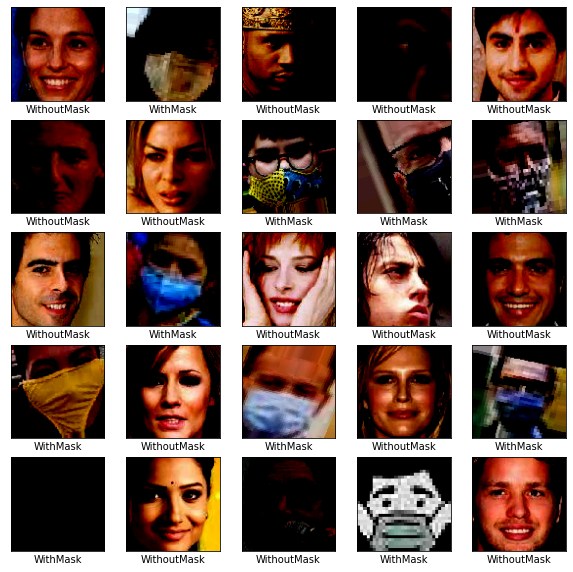

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    image = trainX[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image , cmap='gray')
    plt.xlabel(encode[int(trainY[i][[1]])])

plt.show()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    mode = "auto",
    patience = 4,
    restore_best_weights = False,
)

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)
print("[INFO] the model is ready to be compiled...")

[INFO] the model is ready to be compiled...


In [ ]:
lr=2e-4
INIT_LR = 1e-4
EPOCHS = 30
# defining the optimizer for the model
opt = Adam(lr=lr, decay=INIT_LR / EPOCHS)
# compile our model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
start = time()
history= model.fit(trainX, trainY, batch_size=BATCH_SIZE, epochs=50, verbose=1, callbacks=[callback], validation_data=(valX, valY))
print(time()-start)

Epoch 1/50
222/222 [==============================] - 63s 268ms/step - loss: 0.1052 - accuracy: 0.9716 - val_loss: 0.0265 - val_accuracy: 0.9907
Epoch 2/50
222/222 [==============================] - 56s 251ms/step - loss: 0.0287 - accuracy: 0.9924 - val_loss: 0.0176 - val_accuracy: 0.9932
Epoch 3/50
222/222 [==============================] - 59s 266ms/step - loss: 0.0190 - accuracy: 0.9948 - val_loss: 0.0148 - val_accuracy: 0.9945
Epoch 4/50
222/222 [==============================] - 57s 255ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0147 - val_accuracy: 0.9949
Epoch 5/50
222/222 [==============================] - 56s 252ms/step - loss: 0.0079 - accuracy: 0.9983 - val_loss: 0.0155 - val_accuracy: 0.9936
Epoch 6/50
222/222 [==============================] - 55s 250ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.0134 - val_accuracy: 0.9949
Epoch 7/50
222/222 [==============================] - 58s 263ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.0106 - val_ac

Text(0.5, 0, 'Epoch')

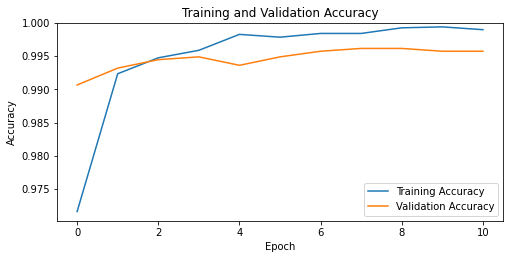

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

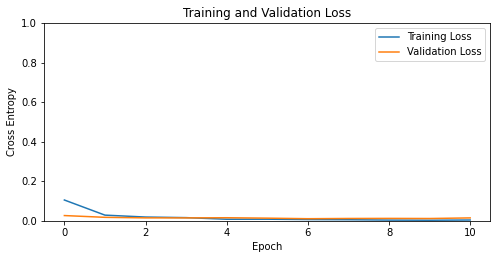

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
score =  model.evaluate(valX, valY, verbose=0)
print('Val accuracy', score[1])

Val accuracy 0.9957609176635742


In [ ]:
model.save("/content/drive/MyDrive/Do_an_AI/lenet5.model", save_format="h5")

In [ ]:
results = model.predict(testX)
predicted_test_labels = np.argmax(results ,axis = 1)
print(predicted_test_labels)

74/74 [==============================] - 15s 190ms/step
[0 1 1 ... 0 1 0]


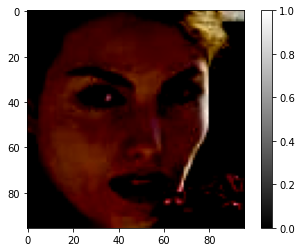

WithoutMask


In [ ]:
image = testX[2]
plt.figure()
plt.imshow(image , cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

print(encode[predicted_test_labels[2]])

In [ ]:
 test_labels = np.argmax(testY, axis = 1)

In [ ]:
print(test_labels)

[0 1 1 ... 0 1 0]


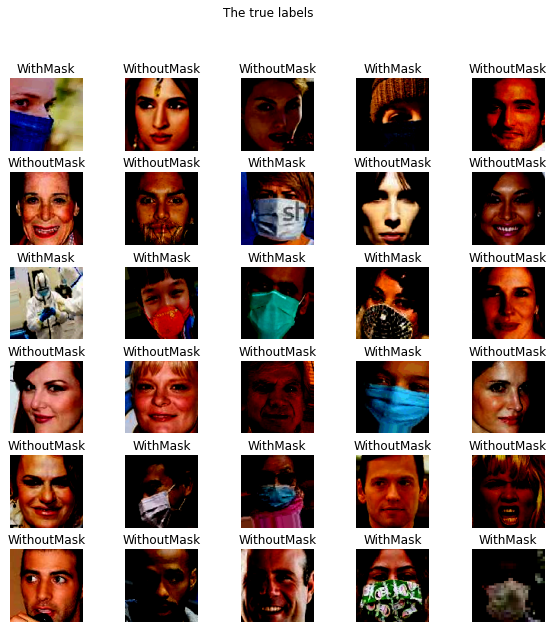

In [ ]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)

    image = testX[n]
    plt.imshow(image)
    plt.title(encode[test_labels[n]])
    plt.axis('off')
_ = plt.suptitle("The true labels")


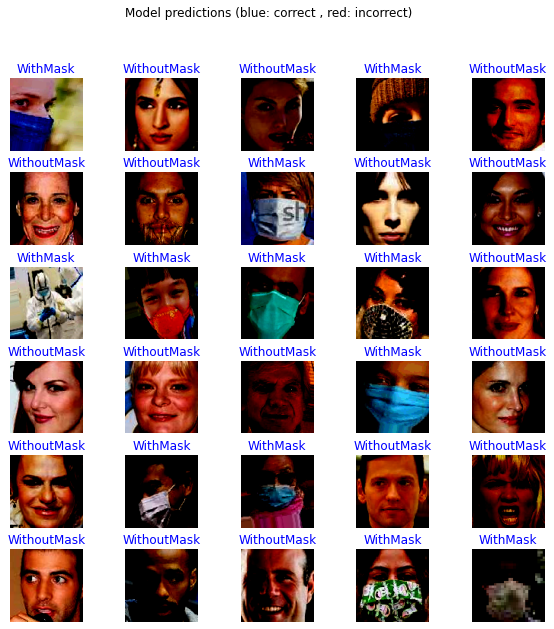

In [ ]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)

    image = testX[n]
    plt.imshow(image)
    color = "blue" if predicted_test_labels[n] == test_labels[n] else "red"
    plt.title(encode[predicted_test_labels[n]], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct , red: incorrect)")


In [ ]:
loss, acc = model.evaluate(testX , testY)
print("Model accuracy: {:5.2f}%".format(100*acc))

74/74 [==============================] - 14s 191ms/step - loss: 0.0146 - accuracy: 0.9970
Model accuracy: 99.70%
